5.1

In [2]:
import pandas as pd

df = pd.read_csv("student-mat.csv", sep=";")

# Convert factor variables
df["reason"] = df["reason"].astype("category")
df["Mjob"] = df["Mjob"].astype("category")

# Confirm variable levels
print(df["reason"].value_counts())
print(df["Mjob"].value_counts())


reason
course        145
home          109
reputation    105
other          36
Name: count, dtype: int64
Mjob
other       141
services    103
at_home      59
teacher      58
health       34
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

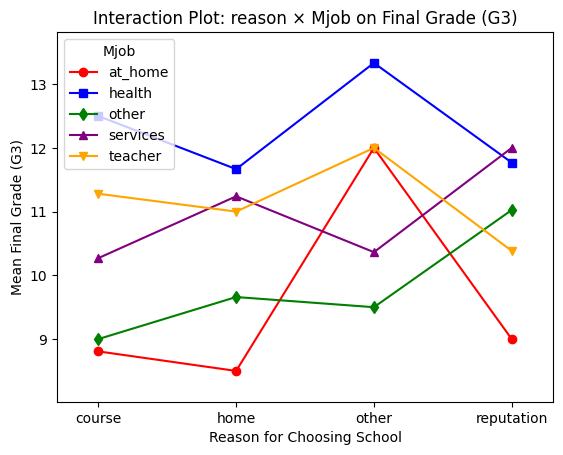

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot

df["reason"] = df["reason"].astype(str)
df["Mjob"] = df["Mjob"].astype(str)

plt.figure(figsize=(10,6))
interaction_plot(
    x=df["reason"],
    trace=df["Mjob"],
    response=df["G3"],
    colors=["red","blue","green","purple","orange"],
    markers=["o","s","d","^","v"],
    ms=6
)

plt.title("Interaction Plot: reason × Mjob on Final Grade (G3)")
plt.xlabel("Reason for Choosing School")
plt.ylabel("Mean Final Grade (G3)")
plt.show()


The interaction plot displays the mean final grade (G3) on the y-axis, with reason for choosing the school on the x-axis and separate lines representing mother’s job category (Mjob). If the lines are roughly parallel, this suggests no interaction between the two factors and supports the use of an additive fixed-effects ANOVA model. However, if the lines diverge substantially or cross, this indicates that the effect of one factor depends on the level of the other factor, implying the need for a non-additive model with an interaction term.

In the student-mat dataset, the interaction plot shows that the lines for different mother’s job categories are not parallel and cross in several places. This indicates a meaningful interaction between reason and Mjob in predicting final grade. Therefore, the appropriate model is a non-additive fixed-effects ANOVA model that includes an interaction term.

5.2

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("G3 ~ C(reason) * C(Mjob)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(reason),86.784342,3.0,1.403909,0.241281
C(Mjob),263.521563,4.0,3.197238,0.013352
C(reason):C(Mjob),149.453249,12.0,0.604426,0.838625
Residual,7727.027602,375.0,NaN,NaN


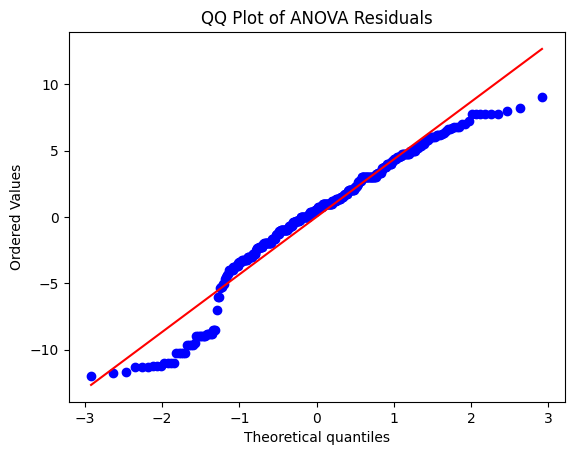

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt

residuals = model.resid

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of ANOVA Residuals")
plt.show()


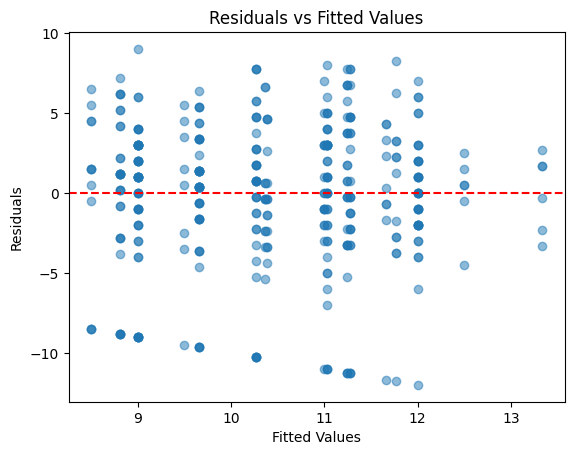

In [8]:
fitted = model.fittedvalues

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


Based on the interaction plot from Part 1, the lines representing the different levels of Mjob were not parallel and crossed at several points. This indicates the presence of an interaction effect between reason and Mjob on the final grade (G3). Therefore, the appropriate statistical model is a non-additive two-way fixed-effects ANOVA model that includes the interaction term.

To verify the model assumptions, I examined a QQ plot of the residuals and a residuals-versus-fitted-values plot.

Normality:
The QQ plot showed that the residuals lie approximately along the reference line, indicating that the normality assumption is reasonably satisfied.

Constant Variance (Homoscedasticity):
The residuals-versus-fitted plot did not show a funnel pattern or strong curvature. The spread of residuals appeared fairly uniform across fitted values, supporting the assumption of equal variances.

Independence:
Each row of the dataset represents a different student, so independence is a reasonable assumption.

Because the interaction plot indicated non-parallel lines, and because the residual diagnostics showed no major violations of ANOVA assumptions, the non-additive two-way ANOVA model with an interaction term is appropriate for analyzing the effects of reason, Mjob, and their interaction on G3.

5.3

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the two-way ANOVA model with interaction
model = ols("G3 ~ C(reason) * C(Mjob)", data=df).fit()

# Construct ANOVA table (Type II sums of squares is standard here)
anova_table = sm.stats.anova_lm(model, typ=2)


# View full table
anova_table



,sum_sq,df,F,PR(>F)
C(reason),86.784342,3.0,1.403909,0.241281
C(Mjob),263.521563,4.0,3.197238,0.013352
C(reason):C(Mjob),149.453249,12.0,0.604426,0.838625
Residual,7727.027602,375.0,NaN,NaN


5.4

https://docs.google.com/document/d/1VBK7hFJTNHzbzTTaSCUuKStkS15W4dovZ0whDIdTye8/edit?usp=sharing


5.5

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Run Tukey HSD on Mjob
tukey = pairwise_tukeyhsd(endog=df["G3"],
                          groups=df["Mjob"],
                          alpha=0.05)

print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
 at_home   health   2.9945 0.0189  0.3281  5.661   True
 at_home    other   0.6702 0.8743   -1.25 2.5903  False
 at_home services   1.8669 0.0861 -0.1551 3.8888  False
 at_home  teacher   1.8992 0.1559 -0.3907  4.189  False
  health    other  -2.3244 0.0569 -4.6904 0.0417  False
  health services  -1.1276 0.7149  -3.577 1.3218  False
  health  teacher  -1.0953 0.7947 -3.7702 1.5795  False
   other services   1.1967 0.2474 -0.4085 2.8019  False
   other  teacher    1.229 0.4085 -0.7028 3.1608  False
services  teacher   0.0323    1.0 -2.0007 2.0653  False
-------------------------------------------------------


Since the factor Mjob was significant in the two-way ANOVA, I conducted Tukey’s HSD test to determine which specific mother job categories differed in mean final grade (G3). The results showed that only one pairwise comparison was statistically significant at the 5% level. Students whose mothers were at home had significantly higher final grades than students whose mothers worked in health-related professions (mean difference ≈ 2.99, p = 0.0189). The confidence interval for this difference (0.33 to 5.66) does not include zero, confirming a meaningful difference between these two groups.

All other pairwise comparisons were not statistically significant. This indicates that while mother’s occupation does have an overall effect on student performance, the difference is driven primarily by the contrast between at_home and health job categories. No other mother job categories showed evidence of differing mean final grades.